In [1]:
import geopandas
import numpy as np
import pandas as pd
from shapely.geometry import Point
import json
import missingno as msn

import seaborn as sns
import matplotlib.pyplot as plt

## Prepare the dataset_election_bfs file for the analysis
First we need to process the big file because there's a lot of not needed data and also matches which have to be brought together from the metadata

In [2]:
ELECTION_RESULTS_FILE = 'election_data/dataset_elections_bfs.json'
METADATA_FILE = 'election_data/NRW2023-metadaten.json'

In [3]:
with open(ELECTION_RESULTS_FILE) as f:
    election_results = json.load(f)
    print(election_results.keys())
with open(METADATA_FILE) as f:
    metadata = json.load(f)
    print(metadata.keys())

dict_keys(['timestamp', 'wahl_jahr', 'spatial_reference', 'stand', 'stand_kantone', 'level_ch', 'level_kantone', 'level_gemeinden'])
dict_keys(['timestamp', 'wahl_jahr', 'spatial_reference', 'quelle', 'bemerkungen', 'stand', 'stand_kantone', 'parteien', 'listenverbindungen', 'kandidat_status'])


Create a map which has the party number as the key and the party name as the value

In [4]:
party_metadata = {party['partei_id']: {'name': party['partei_bezeichnung'][0]['text']} for party in metadata['parteien']}
conservative = ['FDP.Die Liberalen', 'Schweizerische Volkspartei', 'Liberale Partei der Schweiz', 'Landesring der Unabhängigen', 'Schweizer Demokraten', 'Eidgenössisch-Demokratische Union', 'Lega dei Ticinesi', 'Mouvement Citoyens Romands']
middle = ['Christlichdemokratische Volkspartei der Schweiz','Evangelische Volkspartei der Schweiz', 'Christlichsoziale Partei', 'Die Mitte', 'Grünliberale Partei', 'Bürgerlich-Demokratische Partei']
left = ['Sozialdemokratische Partei der Schweiz', 'Partei der Arbeit / Solidarität', 'Grün-Alternative (inkl. POCH)', 'GRÜNE Schweiz']

conservative_id = [1,4,5,6,14,16,18,33]
middle_id = [2,7,8,31,32,34]
left_id = [3,9,12,13]

for value in party_metadata.values():
    if value['name'] in conservative:
        value['group'] = 'conservative'
    elif value['name'] in middle:
        value['group'] = 'middle'
    elif value['name'] in left:
        value['group'] = 'left'
    else:
        value['group'] = 'unrelevant'
party_metadata

{1: {'name': 'FDP.Die Liberalen', 'group': 'conservative'},
 2: {'name': 'Christlichdemokratische Volkspartei der Schweiz',
  'group': 'middle'},
 3: {'name': 'Sozialdemokratische Partei der Schweiz', 'group': 'left'},
 4: {'name': 'Schweizerische Volkspartei', 'group': 'conservative'},
 5: {'name': 'Liberale Partei der Schweiz', 'group': 'conservative'},
 6: {'name': 'Landesring der Unabhängigen', 'group': 'conservative'},
 7: {'name': 'Evangelische Volkspartei der Schweiz', 'group': 'middle'},
 8: {'name': 'Christlichsoziale Partei', 'group': 'middle'},
 9: {'name': 'Partei der Arbeit / Solidarität', 'group': 'left'},
 12: {'name': 'Grün-Alternative (inkl. POCH)', 'group': 'left'},
 13: {'name': 'GRÜNE Schweiz', 'group': 'left'},
 14: {'name': 'Schweizer Demokraten', 'group': 'conservative'},
 16: {'name': 'Eidgenössisch-Demokratische Union', 'group': 'conservative'},
 18: {'name': 'Lega dei Ticinesi', 'group': 'conservative'},
 31: {'name': 'Grünliberale Partei', 'group': 'middle'},

Extract important data from the election results

In [5]:
cantonal_results = dict()
for result in election_results['level_kantone']:
    if result['kanton_nummer'] not in cantonal_results.keys():
        cantonal_results[result['kanton_nummer']] = {
            'name': result['kanton_bezeichnung'],
            'parties': {}
        }
    cantonal_results[result['kanton_nummer']]['parties'][result['partei_id']] = \
        {
            'name': party_metadata[result['partei_id']]['name'],
            'group': party_metadata[result['partei_id']]['group'],
            'vote_share': result['partei_staerke'],
            'vote_share_delta': result['differenz_partei_staerke'],
            'strongest_party': True if result['flag_staerkste_partei'] else False
        }

In [6]:
municipal_results = dict()
for result in election_results['level_gemeinden']:
    if result['gemeinde_nummer'] not in municipal_results.keys():
        municipal_results[result['gemeinde_nummer']] = {
            'name': result['gemeinde_bezeichnung'],
            'parties': {}
        }
    municipal_results[result['gemeinde_nummer']]['parties'][result['partei_id']] = \
        {
            'name': party_metadata[result['partei_id']]['name'],
            'group': party_metadata[result['partei_id']]['group'],
            'vote_share': result['partei_staerke'],
            'vote_share_delta': result['differenz_partei_staerke'],
            'strongest_party': True if result['flag_staerkste_partei'] else False
        }
municipal_results

{1: {'name': 'Aeugst am Albis',
  'parties': {1: {'name': 'FDP.Die Liberalen',
    'group': 'conservative',
    'vote_share': 12.733669035,
    'vote_share_delta': -3.68737584,
    'strongest_party': False},
   3: {'name': 'Sozialdemokratische Partei der Schweiz',
    'group': 'left',
    'vote_share': 13.582120439,
    'vote_share_delta': 2.0170183829,
    'strongest_party': False},
   4: {'name': 'Schweizerische Volkspartei',
    'group': 'conservative',
    'vote_share': 34.241567221,
    'vote_share_delta': 3.8606078221,
    'strongest_party': True},
   7: {'name': 'Evangelische Volkspartei der Schweiz',
    'group': 'middle',
    'vote_share': 3.845623232,
    'vote_share_delta': 0.6181528912,
    'strongest_party': False},
   9: {'name': 'Partei der Arbeit / Solidarität',
    'group': 'left',
    'vote_share': 0.193143409,
    'vote_share_delta': 0.0310330265,
    'strongest_party': False},
   12: {'name': 'Grün-Alternative (inkl. POCH)',
    'group': 'left',
    'vote_share': 0.

Make evaluation on party strength on municipal level

In [7]:
def calc_winning_group(party_dict: dict, attribute_to_sum: str) -> str:
    """Takes the parties dictionary iterates through it and sums the attribute together which are defined in the attribute to sum. It's a necessity that the attribute_to_sum is existing in the dictionary, otherwise it will fail. Returns the winning group."""
    conservative_sum = 0
    middle_sum = 0
    left_sum = 0
    for key, value in party_dict.items():
        if value[attribute_to_sum] is None:
            pass
        else:
            if key in conservative_id:
                conservative_sum += value[attribute_to_sum]
            elif key in middle_id:
                middle_sum += value[attribute_to_sum]
            elif key in left_id:
                left_sum += value[attribute_to_sum]
    if conservative_sum > middle_sum and conservative_sum > left_sum:
        return 'conservative'
    elif middle_sum > conservative_sum and middle_sum > left_sum:
        return 'middle'
    elif left_sum > middle_sum and left_sum > conservative_sum:
        return 'left'

In [8]:
winner_aggregation = {'conservative': [], 'middle': [], 'left': []}
grower_aggregation = {'conservative': [], 'middle': [], 'left': []}
for _id, municipal_data in municipal_results.items():
    municipal_data['vote_winner'] = calc_winning_group(municipal_data['parties'], 'vote_share')
    municipal_data['growth_winner'] = calc_winning_group(municipal_data['parties'], 'vote_share_delta')
    if municipal_data['vote_winner'] == 'conservative':
        winner_aggregation['conservative'].append(_id)
    elif municipal_data['vote_winner'] == 'middle':
        winner_aggregation['middle'].append(_id)
    elif municipal_data['vote_winner'] == 'left':
        winner_aggregation['left'].append(_id)
    
    if municipal_data['growth_winner'] == 'conservative':
        grower_aggregation['conservative'].append(_id)
    elif municipal_data['growth_winner'] == 'middle':
        grower_aggregation['middle'].append(_id)
    elif municipal_data['growth_winner'] == 'left':
        grower_aggregation['left'].append(_id)

# Color schema for the three buckets
We decided to have the SVP green for the conservative block, the orange from the middle for the middle parties and the red from the social party for the left-wing parties. This is a very broad simplification but we're thinking that the viewer can associate those colors directly. Of course there are nuances in the party but it's also mostly how the parties collaborate in parliament.

In [9]:
CONSERVATIVE = '#009f4f'
MIDDLE =  '#ff9b00'
LEFT = '#E4002B'

In [47]:
swiss_map = geopandas.read_file('swisstopo/Hoheitsgebiete.shp')
swiss_map['COLOR_GROWER'] = '#000000'
swiss_map['COLOR_WINNER'] = '#000000'
swiss_map.loc[swiss_map['BFS_NUMMER'].isin(grower_aggregation['conservative']), 'COLOR_GROWER'] = CONSERVATIVE
swiss_map.loc[swiss_map['BFS_NUMMER'].isin(grower_aggregation['middle']), 'COLOR_GROWER'] = MIDDLE
swiss_map.loc[swiss_map['BFS_NUMMER'].isin(grower_aggregation['left']), 'COLOR_GROWER'] = LEFT
swiss_map.loc[swiss_map['BFS_NUMMER'].isin(winner_aggregation['conservative']), 'COLOR_WINNER'] = CONSERVATIVE
swiss_map.loc[swiss_map['BFS_NUMMER'].isin(winner_aggregation['middle']), 'COLOR_WINNER'] = MIDDLE
swiss_map.loc[swiss_map['BFS_NUMMER'].isin(winner_aggregation['left']), 'COLOR_WINNER'] = LEFT
swiss_map

,UUID,DATUM_AEND,DATUM_ERST,ERSTELL_J,ERSTELL_M,REVISION_J,REVISION_M,GRUND_AEND,HERKUNFT,HERKUNFT_J,...,KANTONSNUM,ICC,EINWOHNERZ,HIST_NR,BFS_NUMMER,GEM_TEIL,GEM_FLAECH,SHN,geometry,COLOR
0,{D5A9677C-FE38-44F6-B0E8-3177F6252C81},2022-11-09,2008-11-24,2000,1,2023,1,Verbessert,AV,2023,...,18.0,CH,4650.0,16065.0,3762,0,43861.0,CH18433762,"POLYGON Z ((2812956.113 1194956.023 2980.122, ...",#009f4f
1,{B55F9EAE-EB69-4468-A41C-7BB28A6699EE},2022-11-09,2008-11-24,2006,1,2023,1,Verbessert,AV,2023,...,8.0,CH,9490.0,15478.0,1631,0,43003.0,CH08001631,"POLYGON Z ((2715953.052 1184819.358 3402.836, ...",#009f4f
2,{AB2BA4A5-EB8C-40C7-A259-271DAC93C767},2022-11-09,2008-11-24,2000,1,2023,1,Verbessert,AV,2023,...,18.0,CH,1513.0,16066.0,3746,0,34404.0,CH18433746,"POLYGON Z ((2803369.136 1191207.211 3111.081, ...",#009f4f
3,{550D0610-1EE3-4748-8F29-88072753FFDC},2022-11-09,2008-11-24,2000,1,2023,1,Verbessert,AV,2023,...,18.0,CH,2391.0,16068.0,3543,0,32377.0,CH18413543,"POLYGON Z ((2757776.421 1165789.462 2730.100, ...",#009f4f
4,{5B0C1705-1D2B-4E53-9970-6BC3DE33A0F7},2022-11-09,2008-11-24,1997,1,2023,1,Verbessert,AV,2023,...,23.0,CH,10609.0,16601.0,6037,0,30191.0,CH23036037,"POLYGON Z ((2588810.990 1085590.669 3576.258, ...",#009f4f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,{7FAC8A17-64F7-4920-B7EC-29A4B4F3630E},2022-11-09,2008-11-24,1997,1,2023,1,Verbessert,AV,2023,...,19.0,CH,NaN,12508.0,4257,3,NaN,CH19094257,"POLYGON Z ((2627214.259 1260872.131 482.512, 2...",#009f4f
2274,{454AF364-1D3A-4EC8-9033-B5FF8320DBB0},2022-11-09,2008-11-24,2002,1,2023,1,Verbessert,AV,2023,...,16.0,CH,NaN,14100.0,3104,2,NaN,CH16003104,"POLYGON Z ((2745229.705 1250219.359 783.966, 2...",#ff9b00
2275,{CF0F9771-1C72-4F3D-9476-8D928A01C031},2022-11-09,2008-11-24,2002,1,2023,1,Verbessert,AV,2023,...,16.0,CH,NaN,14102.0,3111,3,NaN,CH16003111,"POLYGON Z ((2763958.831 1257025.919 643.663, 2...",#ff9b00
2276,{3063AE38-1248-4F21-BADA-F166674E4967},2022-11-10,2008-11-24,2000,1,2023,1,Verbessert,AV,2023,...,2.0,CH,NaN,15155.0,582,2,NaN,CH02500582,"POLYGON Z ((2640788.950 1174038.050 563.770, 2...",#ff9b00


<Axes: >

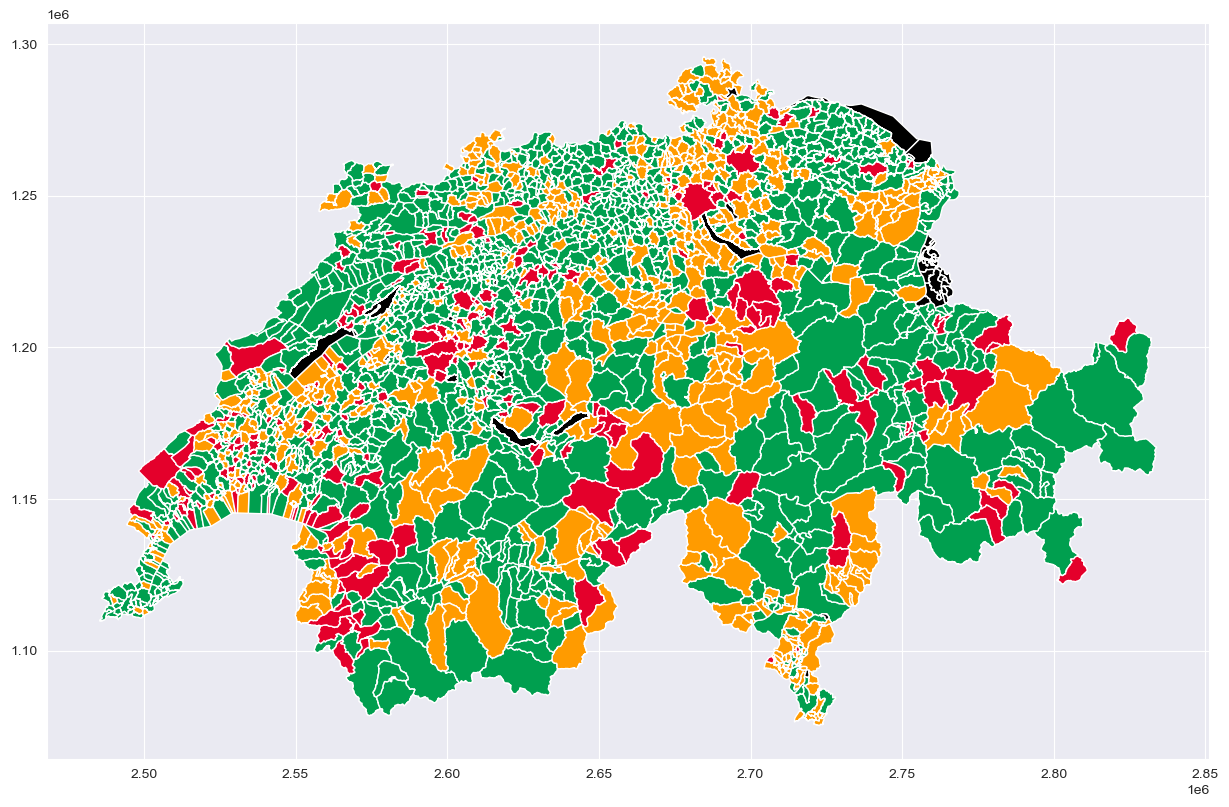

In [48]:
swiss_map.plot(color=swiss_map['COLOR_GROWER'], figsize=(15,10))